In [1]:
%matplotlib nbagg
import time
import h5py
import matplotlib.pylab as plt
import numpy as np
import dedalus.public as de
from dedalus.extras import flow_tools

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [3]:
nr = 128

r_in = 5. # cm
r_out = 3*r_in
h = 10. # cm

nu = 3.26e-3 # cm^2/s
eta = 2000 # cm^2/s
rho = 6 # g/cm^3
B0 = 3000 # G

In [4]:
d = r_out - r_in
eps = h/d
K = np.pi/h * np.sqrt(1+eps**2)
Omega_in = 313.55 # rad/s # higher precision
Omega_out = 37.9 # rad/s
Re_in = Omega_in/(nu*K**2)
Re_out = Omega_out/(nu*K**2)
zeta_bar = 2*(r_out**2 * Omega_out - r_in**2 * Omega_in)/((r_out**2 - r_in**2)*np.sqrt(Omega_in*Omega_out))
print("Re_in = {}; Re_out = {}".format(Re_in,Re_out))
print("zeta bar = {}".format(zeta_bar))

Re_in = 487258.5449548315; Re_out = 58896.823006819046
zeta bar = 0.06318130680011043


In [5]:
r = de.Chebyshev('r',nr,interval=[r_in, r_out])
domain = de.Domain([r])#,grid_dtype=np.double)

nr2 = 192#384
r2 = de.Chebyshev('r',nr2,interval=[r_in, r_out])
domain2 = de.Domain([r2])#,grid_dtype=np.double)

In [6]:
r_g = r.grid()

In [7]:
B = (Omega_out - Omega_in)/(1/r_out**2 - 1/r_in**2)
A = Omega_in - B/r_in**2

Omega = A + B/r_g**2

In [8]:
omega = domain.new_field()
vorticity = domain.new_field()
r2_omega = domain.new_field()

In [9]:
variables = ['u','v','w','Br','Bphi','Bz','p','vr','wr','Bphi_r']
gmri1 = de.EVP(domain,variables, 'sigma')
gmri2 = de.EVP(domain2,variables, 'sigma')

for gmri in [gmri1, gmri2]:
    gmri.parameters['nu'] = nu
    gmri.parameters['eta'] = eta
    gmri.parameters['rho'] = rho
    gmri.parameters['u0'] = 1
    gmri.parameters['u0r'] = 1
    gmri.parameters['B0'] = B0
    gmri.parameters['pi'] = np.pi
    gmri.parameters['k'] = np.pi/h
    gmri.parameters['A'] = A
    gmri.parameters['B'] = B
    gmri.substitutions['ru0'] = '(r*r*A + B)' # u0 = r Omega(r) = Ar + B/r
    gmri.substitutions['rrdu0'] = '(A*r*r-B)' # du0/dr = A - B/r^2

2016-05-07 12:06:50,416 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-05-07 12:06:50,417 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [10]:
# Equations with dz -> 1j*k
for gmri in [gmri1, gmri2]:
    gmri.add_equation("r**2*sigma*(u) - nu*r**2*(-k**2*u + 1j*k*wr)  + r**2*dr(p)/rho - 2*ru0*v - r**2*B0*1j*k*Br/(4*pi*rho) = 0")
    gmri.add_equation("r**2*sigma*(v) - nu*(r**2*dr(vr) + r*vr - r**2*k**2*v - v) + ru0*u + u*rrdu0 - r**2*B0*1j*k*Bphi/(4*pi*rho) = 0")
    gmri.add_equation("r*sigma*(w) - nu*(r*dr(wr) + wr - r*k**2*w) + 1j*r*k*p/rho - r*B0*1j*k*Bz/(4*pi*rho) = 0")
    gmri.add_equation("r*dr(u) + u + r*1j*k*w = 0")
    gmri.add_equation("vr - dr(v) = 0")
    gmri.add_equation("wr - dr(w) = 0")
    gmri.add_equation("sigma*(Br) - eta*(-k**2*Br - 1j*k*dr(Bz)) - B0*1j*k*u = 0")
    gmri.add_equation("r**2*sigma*(Bphi) - eta*(r**2*dr(Bphi_r) - r**2*k**2*Bphi + r*Bphi_r - Bphi) - Br*rrdu0 + ru0*Br - r**2*B0*1j*k*v = 0")
    gmri.add_equation("r*dr(Br) + Br + r*1j*k*Bz = 0")
    gmri.add_equation("Bphi_r - dr(Bphi) = 0")

In [11]:
# boundary conditions
for gmri in [gmri1, gmri2]:
    gmri.add_bc("left(u) = 0")
    gmri.add_bc("left(v) = 0")
    gmri.add_bc("left(w) = 0")
    gmri.add_bc("right(u) = 0")
    gmri.add_bc("right(v) = 0")
    gmri.add_bc("right(w) = 0")
    gmri.add_bc("left(Br) = 0")
    gmri.add_bc("right(Br) = 0")
    gmri.add_bc("left(dr(r*Bphi)) = 0")
    gmri.add_bc("right(dr(r*Bphi)) = 0")

In [12]:
gmri_solver1 = gmri1.build_solver()
gmri_solver2 = gmri2.build_solver()

In [13]:
gmri_solver1.solve(gmri_solver1.pencils[0])
gmri_solver2.solve(gmri_solver2.pencils[0])

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta


In [14]:
def discard_spurious_eigenvalues(lambda1, lambda2):

    """
    lambda1 :: eigenvalues from low res run
    lambda2 :: eigenvalues from high res run

    Solves the linear eigenvalue problem for two different resolutions.
    Returns trustworthy eigenvalues using nearest delta, from Boyd chapter 7.
    """

    # Reverse engineer correct indices to make unsorted list from sorted
    reverse_lambda1_indx = np.arange(len(lambda1)) 
    reverse_lambda2_indx = np.arange(len(lambda2))

    lambda1_and_indx = np.asarray(list(zip(lambda1, reverse_lambda1_indx)))
    lambda2_and_indx = np.asarray(list(zip(lambda2, reverse_lambda2_indx)))

    # remove nans
    lambda1_and_indx = lambda1_and_indx[np.isfinite(lambda1)]
    lambda2_and_indx = lambda2_and_indx[np.isfinite(lambda2)]

    # Sort lambda1 and lambda2 by real parts
    lambda1_and_indx = lambda1_and_indx[np.argsort(lambda1_and_indx[:, 0].real)]
    lambda2_and_indx = lambda2_and_indx[np.argsort(lambda2_and_indx[:, 0].real)]

    lambda1_sorted = lambda1_and_indx[:, 0]
    lambda2_sorted = lambda2_and_indx[:, 0]

    # Compute sigmas from lower resolution run (gridnum = N1)
    sigmas = np.zeros(len(lambda1_sorted))
    sigmas[0] = np.abs(lambda1_sorted[0] - lambda1_sorted[1])
    sigmas[1:-1] = [0.5*(np.abs(lambda1_sorted[j] - lambda1_sorted[j - 1]) + np.abs(lambda1_sorted[j + 1] - lambda1_sorted[j])) for j in range(1, len(lambda1_sorted) - 1)]
    sigmas[-1] = np.abs(lambda1_sorted[-2] - lambda1_sorted[-1])

    if not (np.isfinite(sigmas)).all():
        print("WARNING: at least one eigenvalue spacings (sigmas) is non-finite (np.inf or np.nan)!")

    # Nearest delta
    delta_near = np.array([np.nanmin(np.abs(lambda1_sorted[j] - lambda2_sorted)/sigmas[j]) for j in range(len(lambda1_sorted))])

    # Discard eigenvalues with 1/delta_near < 10^6
    lambda1_and_indx = lambda1_and_indx[np.where((1.0/delta_near) > 1E6)]
    #print(lambda1_and_indx)

    lambda1 = lambda1_and_indx[:, 0]
    indx = lambda1_and_indx[:, 1]

    return lambda1, indx

In [15]:
# Discard spurious eigenvalues
ev1 = gmri_solver1.eigenvalues
ev2 = gmri_solver2.eigenvalues
goodeigs, goodeigs_indices = discard_spurious_eigenvalues(ev1, ev2)

In [16]:
goodeigs_index = np.nanargmax(goodeigs.real)
marginal_mode_index = int(goodeigs_indices[goodeigs_index])

gmri_solver1.set_state(marginal_mode_index)

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [17]:
goodeigs[goodeigs_index]

(0.013090298448670988+2.4218420608903909e-09j)

In [67]:
z_g = domain.grid(0)

p = gmri_solver1.state['p']['g']#.real
u = gmri_solver1.state['u']['g']#.real
v = gmri_solver1.state['v']['g']#.real
w = gmri_solver1.state['w']['g']#.real
vr = gmri_solver1.state['vr']['g']#.real
wr = gmri_solver1.state['wr']['g']#.real
Br = gmri_solver1.state['Br']['g']#.real
Bphi = gmri_solver1.state['Bphi']['g']#.real
Bz = gmri_solver1.state['Bz']['g']#.real

#scale_factor = 2.7/np.abs(v['g']).max()
scale_factor = 2.7/np.abs(v).max()
scale_factor = 2.7/v[np.argmax(v)]
print("scaling by {}".format(scale_factor))

scaling by (580.664424987981-425.7203563169011j)


(-0.5912731348746005-0.8064713757943072j)


<IPython.core.display.Javascript object>


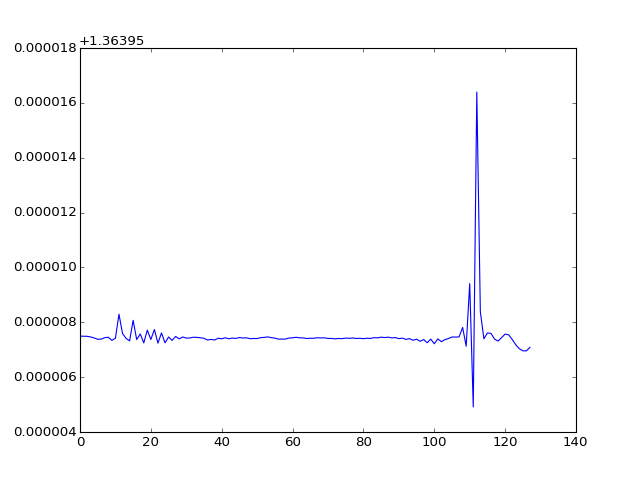

In [76]:
# Normalize all real or imag
n = np.abs(gmri_solver1.state['v']['g'])[13]
a = gmri_solver1.state['v']['g'].real[13]/n
b = gmri_solver1.state['v']['g'].imag[13]/n
scale = 1j*a/(b*(a**2/b+b)) + 1./(a**2/b +b)

print(scale)
plt.figure()
#plt.plot(z_g, v.real/scale)
#plt.plot(z_g, v.imag/scale)
plt.plot(v.real/v.imag)

<IPython.core.display.Javascript object>


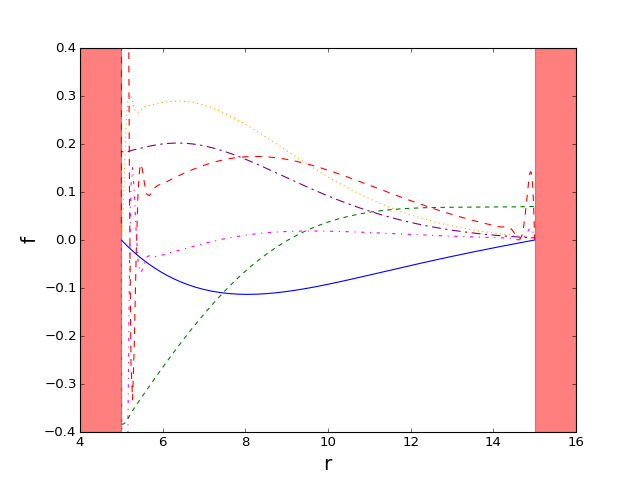

(-0.4, 0.4)

In [61]:
plt.figure()
plt.plot(z_g,scale_factor*v,'k',ls='--', color = "red")
plt.plot(z_g,scale_factor*u/3.,'k',ls='dotted', color = "orange")
plt.plot(z_g,scale_factor*w*0.07,'k',ls='-.', color = "magenta")
plt.plot(z_g,scale_factor*Br/np.sqrt(4*np.pi*rho),'k', color = "blue")
plt.plot(z_g,scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4], color = "purple")
plt.plot(z_g,scale_factor*Bz/np.sqrt(4*np.pi*rho),'k',dashes=[4,4], color = "green")
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4, 5, alpha=0.5, color='red')
plt.axvspan(15, 16, alpha=0.5, color='red')

plt.xlim(4,16)
plt.ylim(-0.4,0.4)

<IPython.core.display.Javascript object>


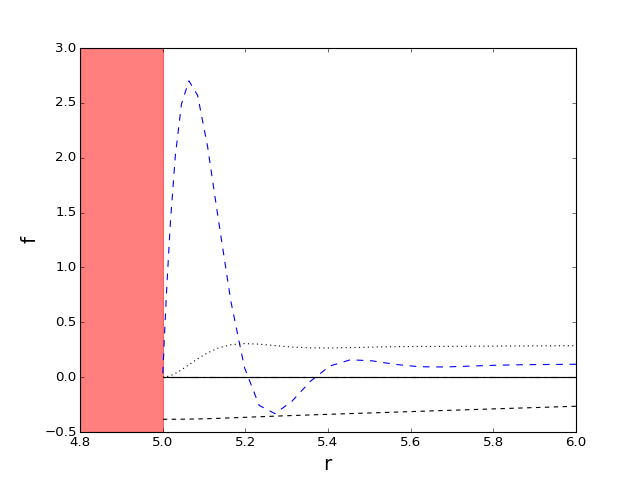

(-0.5, 3)

In [49]:
plt.figure()
plt.plot(z_g,scale_factor*v['g'],'b',ls='--')
plt.plot(z_g,scale_factor*u['g']/3,'k',ls='dotted')
plt.plot(z_g,scale_factor*w['g']*0.07,'k',ls='-.')
plt.plot(z_g,scale_factor*Br['g']/np.sqrt(4*np.pi*rho),'k')
plt.plot(z_g,scale_factor*Bphi['g']/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4])
plt.plot(z_g,scale_factor*Bz['g']/np.sqrt(4*np.pi*rho),'k',dashes=[4,4])
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4.8, 5, alpha=0.5, color='red')

plt.xlim(4.8,6)
plt.ylim(-0.5,3)

<IPython.core.display.Javascript object>


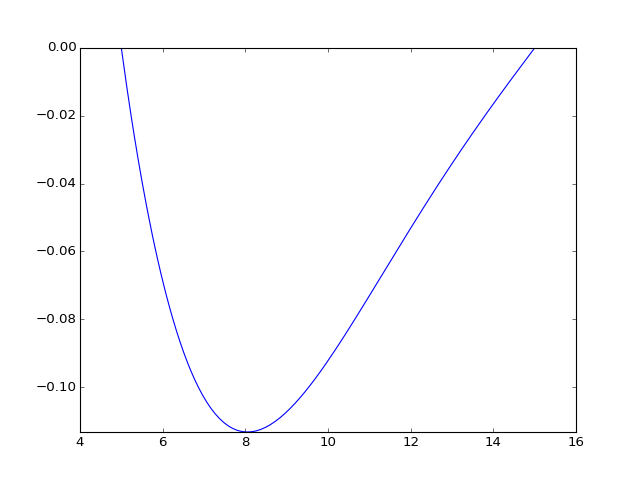

(-0.11325905251494246, -6.0599513785754496e-06)

In [63]:
plt.figure()
#plt.plot(z_g,scale_factor*w['g']*0.07,'k',ls='-.', color = "magenta")
plt.plot(z_g,scale_factor*Br/np.sqrt(4*np.pi*rho),'k', color = "blue")
plt.ylim(np.min(scale_factor*Br/np.sqrt(4*np.pi*rho)), np.max(scale_factor*Br/np.sqrt(4*np.pi*rho)))

<IPython.core.display.Javascript object>


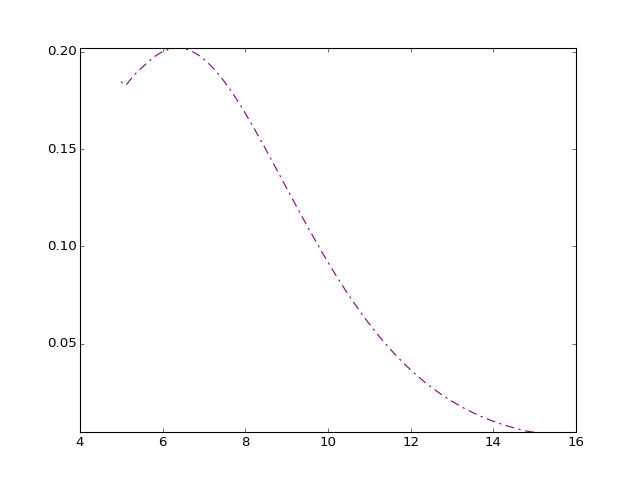

(0.0046974514429488313, 0.20194945219690691)

In [66]:
plt.figure()
plt.plot(r_g, scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4], color = "purple")
plt.ylim(np.min(scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5), np.max(scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5))